In [1]:
import math
import random

import numpy as np
import tensorflow as tf
import cv2
import os
from collections import Counter
import xml.etree.ElementTree as ET
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

slim = tf.contrib.slim

/nfshome/xueqin/anaconda3/envs/ge/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [108]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NCHW'#NHWC
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
# ckpt_filename = '/nfshome/xueqin/udalearn/shibai/checkpoints/ssd_300_vgg.ckpt'
ckpt_filename = '/nfshome/xueqin/udalearn/data/result/result_attover_x_01_an/model.ckpt-100000'
# ckpt_filename = '/nfshome/xueqin/udalearn/data/result/result_attover_x25_1e-3/model.ckpt-100000'

# ckpt_filename = '/nfshome/xueqin/udalearn/BeerData/tmp/logs/old_output/log1/model.ckpt-10455'

isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

==== (1, 3, 300, 300)
INFO:tensorflow:Restoring parameters from /nfshome/xueqin/udalearn/data/result/result_attover_x_01_an/model.ckpt-100000
================hhhhhhhh================= [0.07       0.10246951 0.04008188 0.09438798]
================wwwwwwww================= [0.07       0.10246951 0.12224974 0.05191339]
================hhhhhhhh================= [0.15       0.22248596 0.07319251 0.22874786 0.10350984 0.17677669]
================wwwwwwww================= [0.15       0.22248596 0.3074085  0.09836158 0.21737064 0.12727922]
================hhhhhhhh================= [0.33       0.41024384 0.16102351 0.5032453  0.22772163 0.38890874]
================wwwwwwww================= [0.33       0.41024384 0.67629874 0.21639547 0.47821543 0.28001428]
================hhhhhhhh================= [0.51       0.5932116  0.24885452 0.7777427  0.35193345 0.6010408 ]
================wwwwwwww================= [0.51       0.5932116  1.045189   0.33442935 0.7390602  0.43274936]
================hhhhhh

In [216]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.01, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)#21
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [217]:
VOC_LABELS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

iou=0
map: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[    0.   324.   621.  2169.   666.  2367.   342.  3289.   350.  3209.  994.   104.   547.   495.   626. 12435.  2041.   977.   232.   343. 586.]
######

iou=0.5

map: [0.         0.98778585     0.99999871 1.         0.76719662     0.80678069        0.99893029 0.99747184 1.         0.83239863 0.89449815 0.66665901      1.         0.93749981     0.90494792     0.94245129     0.66944555     0.56854739    0.99999956     0.9374987      0.99801536]


[   0.  173.  252.  375.  158.  147.  165.  903.  276.  617.  197.   78.   384.  284.  219. 2737.  239.  179.  174.  223.  255.]

total   [311.   389.   576.   393.   657.   254.  1541.   370.  1374.   329.   299.   530.   395.   369.  5227.   592.   311.   396.   302.   361.]



001567.jpg  003249.jpg	004884.jpg  006574.jpg	008234.jpg  009895.jpg
001568.jpg  003251.jpg	004887.jpg  006577.jpg	008237.jpg  009899.jpg
001569.jpg  003252.jpg	004888.jpg  006579.jpg	008238.jpg  009901.jpg
001570.jpg  003257.jpg	004889.jpg  006580.jpg	008239.jpg  009903.jpg
001572.jpg  003263.jpg	004891.jpg  006581.jpg	008240.jpg  009906.jpg
001573.jpg  003264.jpg	004892.jpg  006582.jpg	008242.jpg  009907.jpg
001574.jpg  003265.jpg	004893.jpg  006586.jpg	008243.jpg  009909.jpg
001575.jpg  003266.jpg	004894.jpg  006589.jpg	008245.jpg  009910.jpg
001578.jpg  003267.jpg	004899.jpg  006590.jpg	008246.jpg  009912.jpg
001581.jpg  003268.jpg	004900.jpg  006591.jpg	008247.jpg  009914.jpg
001583.jpg  003275.jpg	004901.jpg  006592.jpg	008249.jpg  009915.jpg
001584.jpg  003276.jpg	004904.jpg  006594.jpg	008255.jpg  009916.jpg
001585.jpg  003277.jpg	004906.jpg  006596.jpg	008256.jpg  009919.jpg
001587.jpg  003278.jpg	004908.jpg  006598.jpg	008257.jpg  009921.jpg
001589.jpg  003281.jpg	004909.jpg  006600.jpg	008259.jpg  009922.jpg
001591.jpg  003283.jpg	004914.jpg  006601.jpg	008264.jpg  009924.jpg
001592.jpg  003286.jpg	004915.jpg  006604.jpg	008265.jpg  009925.jpg
001596.jpg  003287.jpg	004917.jpg  006607.jpg	008266.jpg  009927.jpg
001599.jpg  003288.jpg	004918.jpg  006608.jpg	008267.jpg  009928.jpg
001600.jpg  003289.jpg	004919.jpg  006613.jpg	008270.jpg  009929.jpg
001601.jpg  003291.jpg	004920.jpg  006614.jpg	008271.jpg  009930.jpg
001602.jpg  003295.jpg	004921.jpg  006615.jpg	008273.jpg  009931.jpg
001605.jpg  003297.jpg	004922.jpg  006616.jpg	008274.jpg  009933.jpg
001606.jpg  003298.jpg	004923.jpg  006620.jpg	008276.jpg  009934.jpg
001609.jpg  003302.jpg	004924.jpg  006623.jpg	008277.jpg  009936.jpg
001613.jpg  003304.jpg	004925.jpg  006624.jpg	008278.jpg  009937.jpg
001615.jpg  003305.jpg	004927.jpg  006629.jpg	008283.jpg  009941.jpg
001616.jpg  003306.jpg	004930.jpg  006630.jpg	008286.jpg  009943.jpg
001619.jpg  003309.jpg	004932.jpg  006633.jpg	008287.jpg  009948.jpg
001620.jpg  003310.jpg	004933.jpg  006634.jpg	008288.jpg  009951.jpg
001621.jpg  003312.jpg	004934.jpg  006639.jpg	008289.jpg  009952.jpg
001623.jpg  003314.jpg	004937.jpg  006640.jpg	008290.jpg  009953.jpg
001624.jpg  003315.jpg	004940.jpg  006641.jpg	008291.jpg  009956.jpg
001625.jpg  003317.jpg	004941.jpg  006642.jpg	008298.jpg  009957.jpg
001626.jpg  003318.jpg	004942.jpg  006644.jpg	008303.jpg  009960.jpg
001629.jpg  003319.jpg	004944.jpg  006646.jpg	008304.jpg  009962.jpg
001631.jpg  003321.jpg	004945.jpg  006649.jpg	008305.jpg  009963.jpg
001634.jpg  003322.jpg	004947.jpg  006650.jpg	008308.jpg
001635.jpg  003323.jpg	004949.jpg  006651.jpg	008309.jpg
001637.jpg  003324.jpg	004952.jpg  006653.jpg	008314.jpg
001639.jpg  003326.jpg	004957.jpg  006655.jpg	008321.jpg


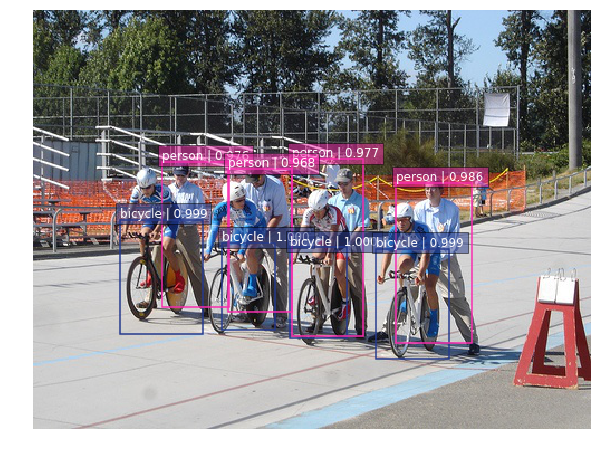

In [243]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/002475.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes = process_image(img)
# print(rscores)
# rclasses = np.append(rclasses, [7])
# rscores = np.append(rscores, [0.556934])
# new=[]
# for i in range(len(rbboxes)):
#     new.append(rbboxes[i])
# new.append(np.array([0.20951445,0.30518728,0.31565428,0.43002427]))

# rbboxes = np.array(new)
 
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[10 10 10 10]


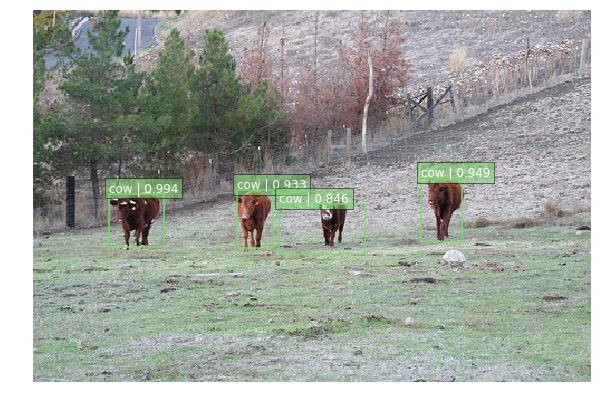

In [100]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/000725.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/006283.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000003.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
# print(rscores)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[20 20 20 20]


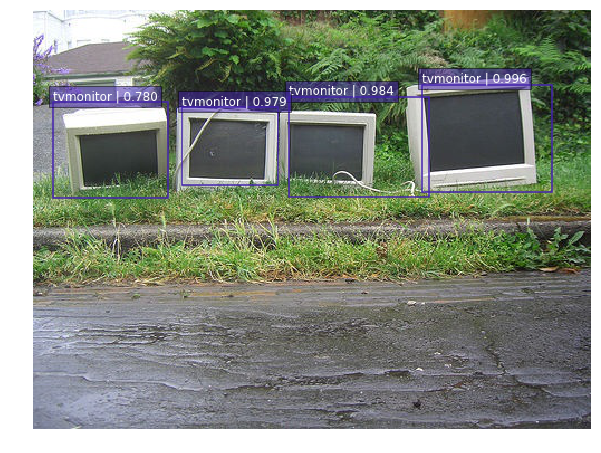

In [101]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/009906.jpg'
## good
# path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/009895.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/006646.jpg'

img = mpimg.imread(path)
rclasses, rscores, rbboxes = process_image(img)
print(rclasses)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [42]:
# def process_video(path):
#     Thickness = 2

#     img = mpimg.imread(path)
#     rclasses, rscores, rbboxes = process_image(img)
#     #res = visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
#     height = img.shape[0]
#     width = img.shape[1]
#     colors = dict()
#     for i in range(rclasses.shape[0]):
#         cls_id = int(rclasses[i])
#         if cls_id >=0:
#             score = rscores[i]
#             if cls_id not in colors:
#                 colors[cls_id] = (random.random()*255, random.random()*255, random.random()*255)
#                 print("true")
#             ymin = int(rbboxes[i, 0] * height)
#             xmin = int(rbboxes[i, 1] * width)
#             ymax = int(rbboxes[i, 2] * height)
#             xmax = int(rbboxes[i, 3] * width)
#             img=cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[int(cls_id)], Thickness,lineType=8)
#             class_name = str(cls_id)
#             cl = voc_dict[class_name]
#             cv2.putText(img, cl, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[cls_id], thickness=2)
#     return img
# #     plt.imshow('drawimg',img)
# #     return res

# path=r'/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/006634.jpg'
# a=process_video(path)

true


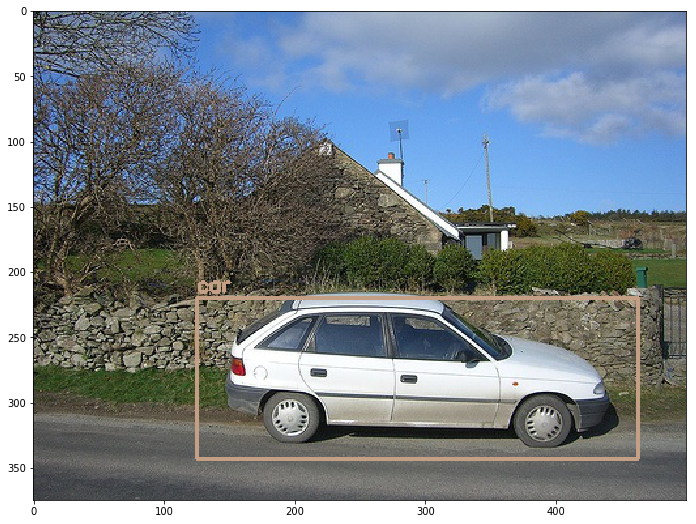

In [43]:
plt.figure(figsize=(16,9))
plt.imshow(a)
plt.show()

[10 10 10 10]


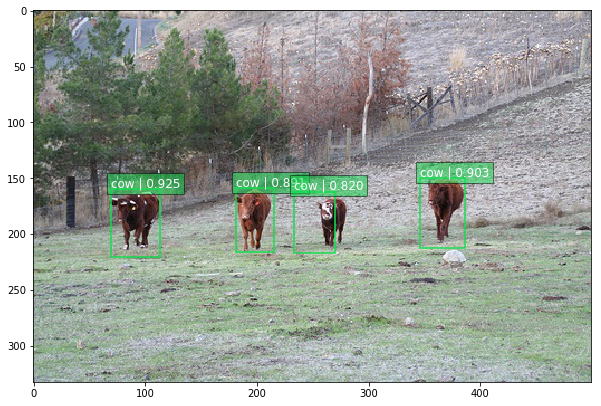

In [28]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit_test/VOC2007/JPEGImages/000725.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000003.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
#我的att-3的结点

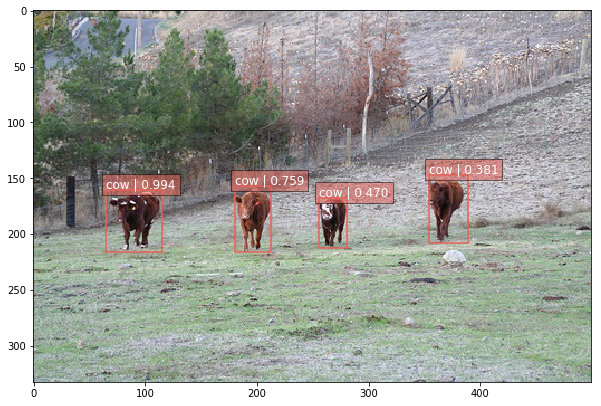

In [14]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000725.jpg'
# path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000003.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)

visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
#原始结点

In [25]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

FileNotFoundError: [Errno 2] No such file or directory: '/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'

In [1]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/006631.jpg'
img = mpimg.imread(path)#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

NameError: name 'mpimg' is not defined

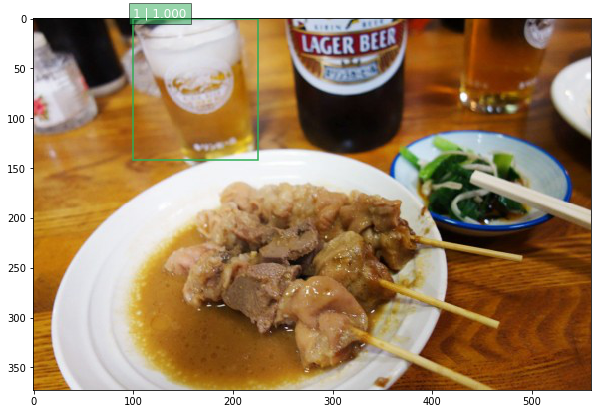

In [48]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/004977.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
#print(type(rclasses), rscores, rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

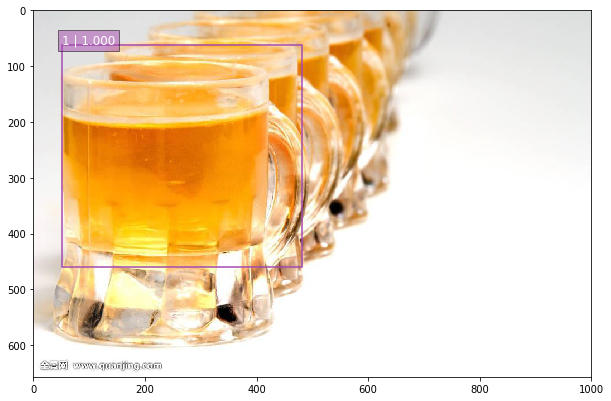

In [38]:
# path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/139.jpg'
path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/Baidu_606.jpeg'
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

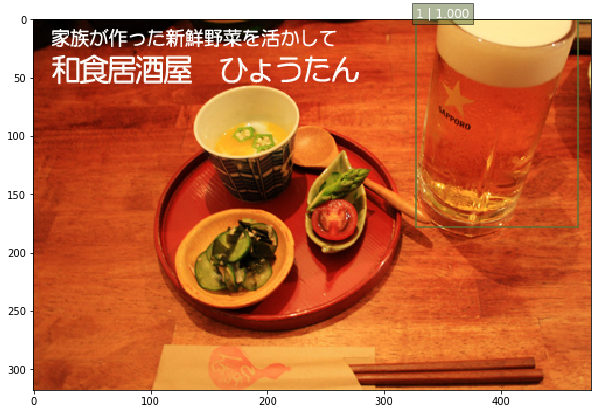

In [39]:
path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/Bing_458.jpeg'
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[[ 0.41373584  0.41153803  0.75597692  0.73916757]]


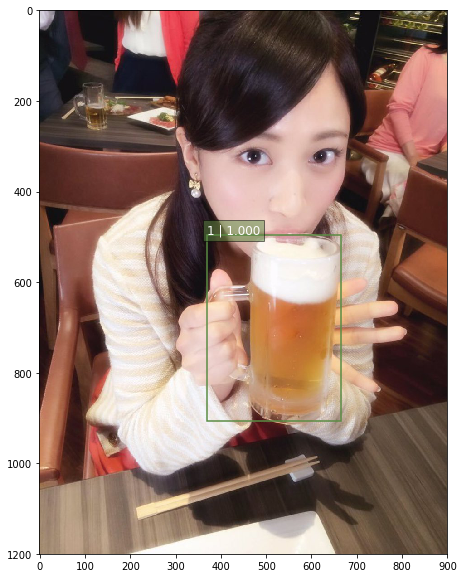

In [43]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

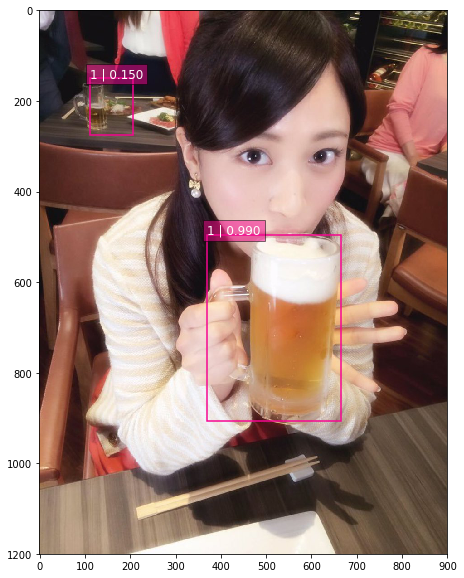

In [69]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses=np.array([1,1])
rscores =  np.array([0.15, 0.99])
rbboxes = np.array([[ 0.125,0.123,0.23,0.230245118],
                    [ 0.41373584,0.41153803,0.75597692,0.73916757]])
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)